In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
import pydot
from IPython.display import Image

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
SCORE_PLOT_TITLE = "Score for the testing for {}"
def plot_score(test_scores, model, param):
    xs = np.arange(len(test_scores)) + 1
    plt.figure(figsize=(15,10))
    plt.plot(xs, test_scores, label="Score")
    plt.xlabel(param)
    plt.ylabel("Score")
    plt.xlim(0, len(test_scores)+1)
    plt.title(SCORE_PLOT_TITLE.format(model))
    plt.grid()
    plt.xticks(np.arange(0, len(test_scores), 5))
    plt.legend();

## Features used

In [4]:
featuresA = ["has_name", "has_image", "has_location",
             "normal_name", "favourites_count",
             "has_biography", "tweet_count",
             "followers_count", "friends_count",
             "ratio_followers_friends", "ratio_friends_followers",
             "ratio_followers_friends_pow", "ratio_friends_followers_pow",
             "has_url", "bot_in_biography",
             "is_listed", "listed_count"]
featuresB = ["tweet_geo", "tweet_fav", "tweet_hashtag", 
             "tweet_url", "tweet_retweet", "tweet_mention", "tweet_reply"]

## Data retreival

In [5]:
cresci2015files = glob("datas/cresci-2015/*/users.csv")
tmp = []
for f in cresci2015files:
    df = pd.read_csv(f, index_col=None, header=0)
    tmp.append(df)
cresci2015 = pd.concat(tmp)
cresci2015 = cresci2015.set_index("id")

In [6]:
cresci2015["tweet_count"] = cresci2015.statuses_count
cresci2015 = cresci2015.fillna(0)
replace_from = ["name", "location", "default_profile_image", "description", "url", "listed_count"]
replace_to = ["has_name", "has_location", "has_image", "has_biography", "has_url", "is_listed"]
cresci2015[replace_to] = cresci2015[replace_from].astype(bool)
cresci2015["normal_name"] = cresci2015.name.str.contains(r"^[a-zA-Z0-9\s\.]+$")
cresci2015["ratio_followers_friends"] = cresci2015.followers_count / cresci2015.friends_count
cresci2015["ratio_friends_followers"] = cresci2015.friends_count / cresci2015.followers_count
cresci2015["ratio_followers_friends_pow"] = cresci2015.followers_count / cresci2015.friends_count**2
cresci2015["ratio_friends_followers_pow"] = cresci2015.friends_count / cresci2015.followers_count**2
cresci2015["bot_in_biography"] = cresci2015.description.str.contains("\Wbot\W").fillna(False)

In [7]:
tweet2015files = glob("datas/cresci-2015/*/tweets.csv")
tmp = []
for f in tweet2015files:
    df = pd.read_csv(f, index_col=None, header=0)
    tmp.append(df)
tweets2015 = pd.concat(tmp)
tweets2015 = tweets2015.set_index("id")
tweets2015 = tweets2015.fillna(0)

/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
repl = lambda x: x.group("name")
tweets2015["source"] = tweets2015.source.str.replace(r"\s*<\s*a\s*href=\".+\">(?P<name>.*)</a>", repl)

In [9]:
all_sources = tweets2015.source.unique()
featuresB.extend(all_sources)

In [10]:
tweets2015_grouped = tweets2015.groupby("user_id")

In [11]:
for i in featuresB:
    cresci2015[i] = 0.0

In [12]:
for group in tweets2015_grouped:
    cresci2015.at[group[0], "tweet_geo"] = group[1].geo.mean()
    cresci2015.at[group[0], "tweet_fav"] = group[1].favorite_count.mean()
    cresci2015.at[group[0], "tweet_hashtag"] = group[1].num_hashtags.mean()
    tmp = np.zeros(len(all_sources))
    for i in group[1].source:
        cresci2015.at[group[0], i] = cresci2015.loc[group[0], i] + 1/len(group[1])
    cresci2015.at[group[0], "tweet_url"] = group[1].num_urls.mean()
    cresci2015.at[group[0], "tweet_retweet"] = group[1].retweet_count.mean()
    cresci2015.at[group[0], "tweet_mention"] = group[1].num_mentions.mean()
    cresci2015.at[group[0], "tweet_reply"] = group[1].reply_count.mean()

In [13]:
cresci2015

,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,created_at,url,lang,...,PINK Nation for iPhone,MOTOBLUR,vk.com pages,Publish Live,Staying Alive on iOS,kinopoisk,LG_SNS_FP_GT_OAuth,Earthquake on iOS,Viivek Killer,GrabInbox
id,,,,,,,,,,,,,,,,,,,,,
1120176186,Madonna Carson,MadonnaCarson,22,11,257,0,0,Fri Jan 25 20:18:39 +0000 2013,0,en,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1124249136,Ardelle Mckee,ArdelleMckee,20,11,226,0,0,Sun Jan 27 07:18:34 +0000 2013,0,en,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1124264132,Isadora Wilson,IsadoraWilson,19,13,281,0,0,Sun Jan 27 07:19:28 +0000 2013,0,en,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1124293891,Genesis Merrill,GenesisMerrill,21,19,237,0,0,Sun Jan 27 07:33:40 +0000 2013,0,en,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1124295318,Kent Caldwell,KentCaldwell3,22,20,262,0,0,Sun Jan 27 07:43:52 +0000 2013,0,en,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1124301420,Drucilla Sellers,DrucillaSeller1,19,14,269,1,0,Sun Jan 27 07:47:15 +0000 2013,0,en,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1124314592,Helaine Taylor,HelaineTaylor,22,13,242,0,0,Sun Jan 27 07:46:58 +0000 2013,0,en,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1124348202,Senaida Hayes,SenaidaHayes,19,8,235,0,0,Sun Jan 27 08:11:56 +0000 2013,0,en,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1124360551,Mayra Glass,MayraGlass11,23,13,265,0,0,Sun Jan 27 08:09:15 +0000 2013,0,en,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Class A
### data exctration and splitting

In [14]:
features = featuresA
X = cresci2015[features].astype("float32").replace([np.inf, -np.inf], np.nan).fillna(0)
Y = (cresci2015.dataset == "TFP") | (cresci2015.dataset == "E13")
Y = Y.astype("int")

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

### Random forest classifier

Best number of estimator : 19
CPU times: user 43.2 s, sys: 3.25 ms, total: 43.2 s
Wall time: 43.2 s


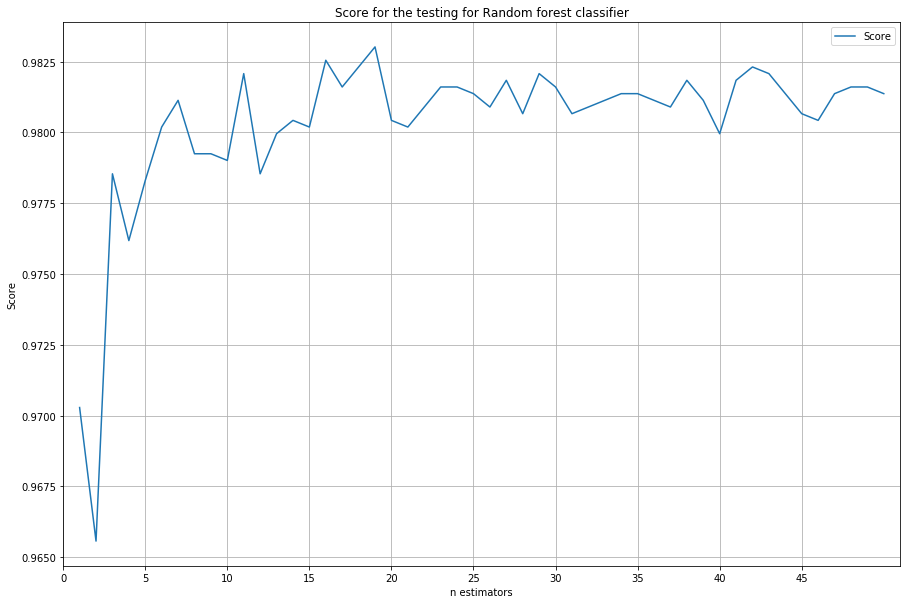

In [16]:
%%time
scores = []
for i in range(50):
    clf = RandomForestClassifier(n_estimators=i+1)
    s = cross_val_score(clf, X_train, Y_train, cv=5)
    scores.append(s.mean())
plot_score(scores, "Random forest classifier", "n estimators");
print("Best number of estimator : " + str(np.argmax(scores) + 1))

Best max depth : 11
CPU times: user 10.5 s, sys: 85 µs, total: 10.5 s
Wall time: 10.5 s


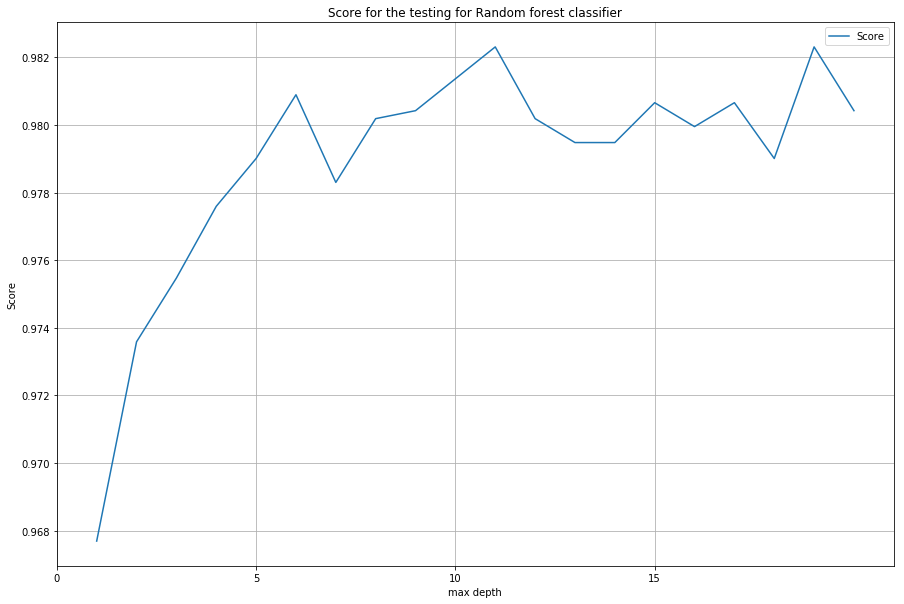

In [17]:
%%time
scores = []
for i in range(20):
    clf = RandomForestClassifier(n_estimators=17, max_depth=i+1)
    s = cross_val_score(clf, X_train, Y_train, cv=5)
    scores.append(s.mean())
plot_score(scores, "Random forest classifier", "max depth");
print("Best max depth : " + str(np.argmax(scores) + 1))

In [18]:
%%time
clf = RandomForestClassifier(n_estimators=17, max_depth=8)
clf.fit(X_train, Y_train)
print("score: " + str(clf.score(X_test, Y_test)))

score: 0.98397737983
CPU times: user 128 ms, sys: 20 µs, total: 128 ms
Wall time: 126 ms


In [19]:
importance = list(zip(features, clf.feature_importances_))
importance.sort(key=lambda x:x[1], reverse=True)
for name,i in importance:
    if i == 0:
        break
    print("{} : {:.3}".format(name, i))

ratio_friends_followers : 0.374
ratio_followers_friends : 0.204
ratio_followers_friends_pow : 0.126
ratio_friends_followers_pow : 0.107
tweet_count : 0.103
favourites_count : 0.0473
friends_count : 0.0138
followers_count : 0.0133
listed_count : 0.00423
has_biography : 0.00353
has_location : 0.00131
has_image : 0.00128
has_url : 0.000664
is_listed : 0.000634
normal_name : 0.000606


### Decision tree classifier

Best max depth : 13
CPU times: user 5.99 s, sys: 21 µs, total: 5.99 s
Wall time: 5.99 s


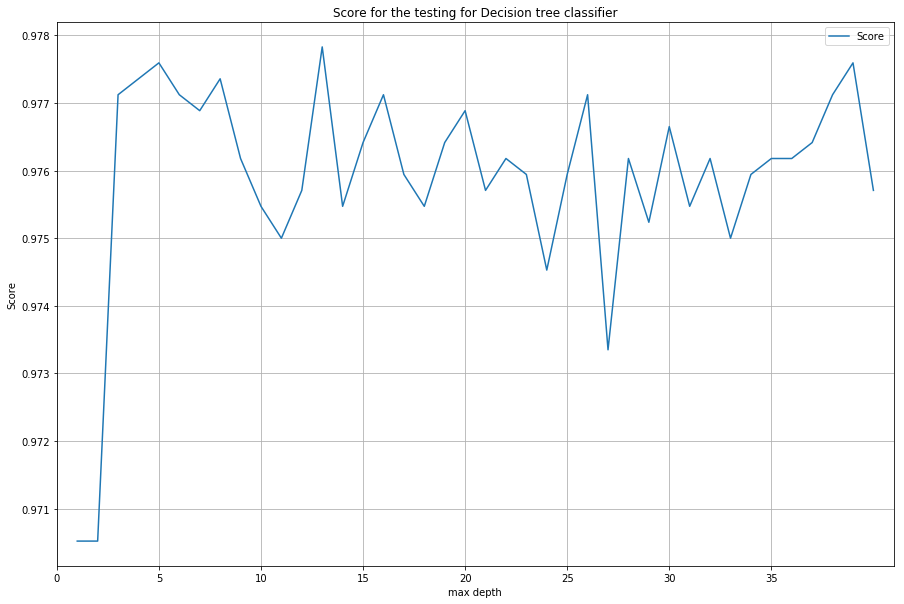

In [20]:
%%time
scores = []
for i in range(40):
    clf = DecisionTreeClassifier(max_depth=i+1)
    s = cross_val_score(clf, X_train, Y_train, cv=5)
    scores.append(s.mean())
plot_score(scores, "Decision tree classifier", "max depth");
print("Best max depth : " + str(np.argmax(scores) + 1))

In [21]:
%%time
clf = DecisionTreeClassifier(max_depth=7)
clf.fit(X_train, Y_train)
print("score: " + str(clf.score(X_test, Y_test)))

score: 0.979264844486
CPU times: user 27.6 ms, sys: 0 ns, total: 27.6 ms
Wall time: 26.8 ms


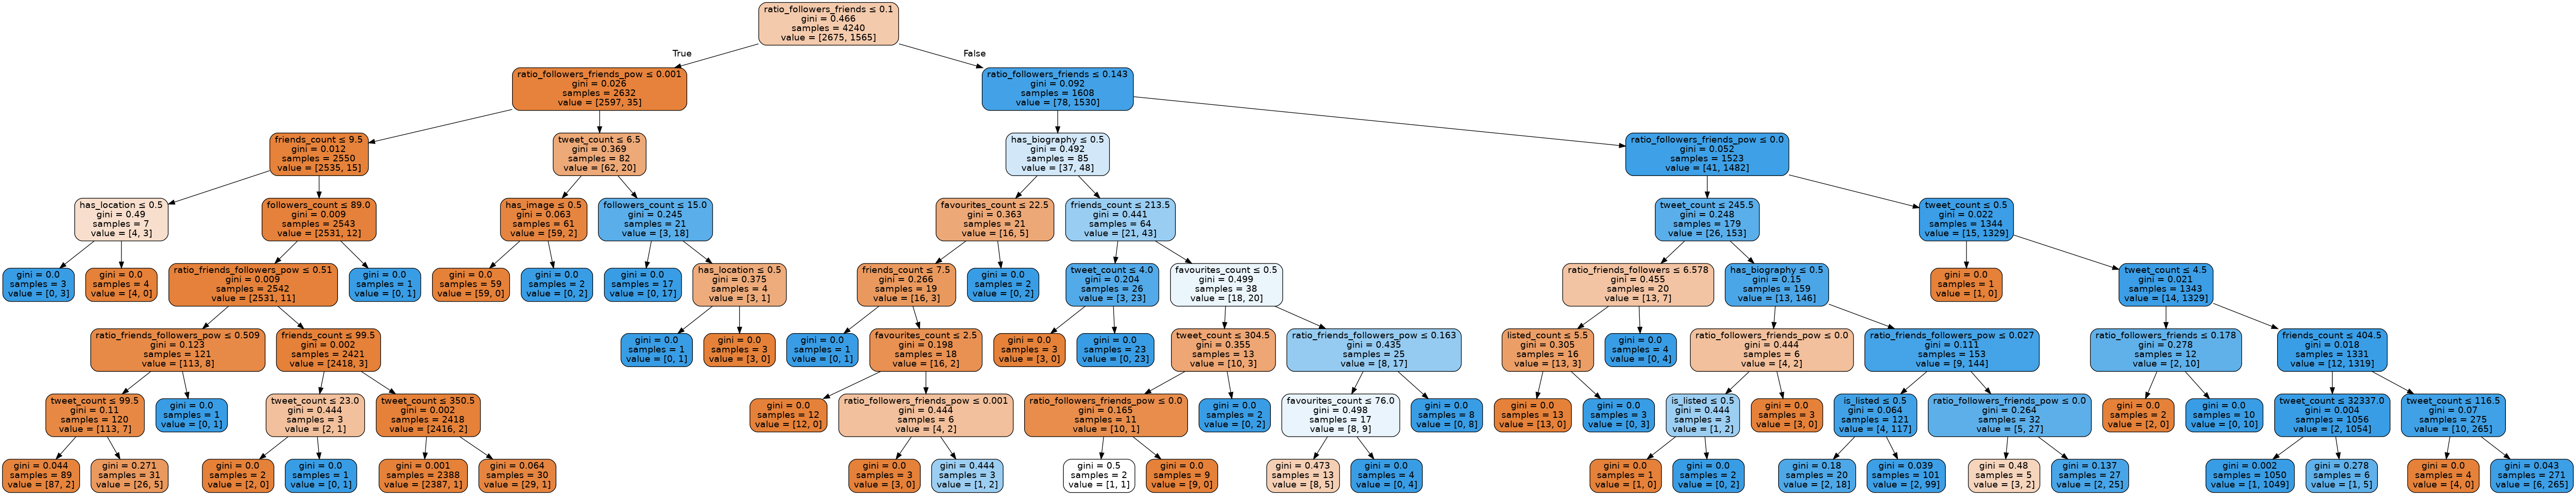

In [22]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=features,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data)
Image(graph[0].create_png())

### Linear SVC

In [23]:
%%time
clf = LinearSVC()
clf.fit(X_train, Y_train)
print("score: " + str(clf.score(X_test, Y_test)))

score: 0.955702167766
CPU times: user 301 ms, sys: 3.35 ms, total: 305 ms
Wall time: 303 ms


### KNN

Best number of neighbors : 3
CPU times: user 1.65 s, sys: 31 µs, total: 1.65 s
Wall time: 1.65 s


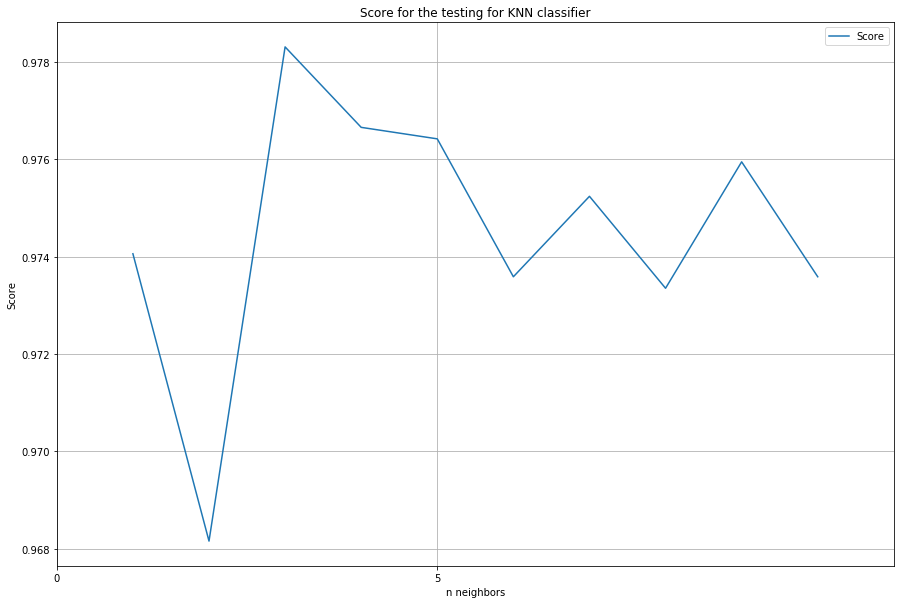

In [24]:
%%time
scores = []
for i in range(10):
    clf = KNeighborsClassifier(n_neighbors=i+1)
    s = cross_val_score(clf, X_train, Y_train, cv=5)
    scores.append(s.mean())
scores = np.array(scores)
plot_score(scores, "KNN classifier", "n neighbors");
print("Best number of neighbors : " + str(scores.argmax() + 1))

In [25]:
%%time
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, Y_train)
print("score: " + str(clf.score(X_test, Y_test)))

score: 0.978322337418
CPU times: user 26.8 ms, sys: 2 µs, total: 26.8 ms
Wall time: 26.5 ms


## Class A + B
### data exctration and splitting

In [26]:
features = featuresA + featuresB
X = cresci2015[features].astype("float32").replace([np.inf, -np.inf], np.nan).fillna(0)
Y = (cresci2015.dataset == "TFP") | (cresci2015.dataset == "E13")
Y = Y.astype("int")

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

### Random forest classifier

Best number of estimator : 12
CPU times: user 1min 36s, sys: 6.47 ms, total: 1min 36s
Wall time: 1min 36s


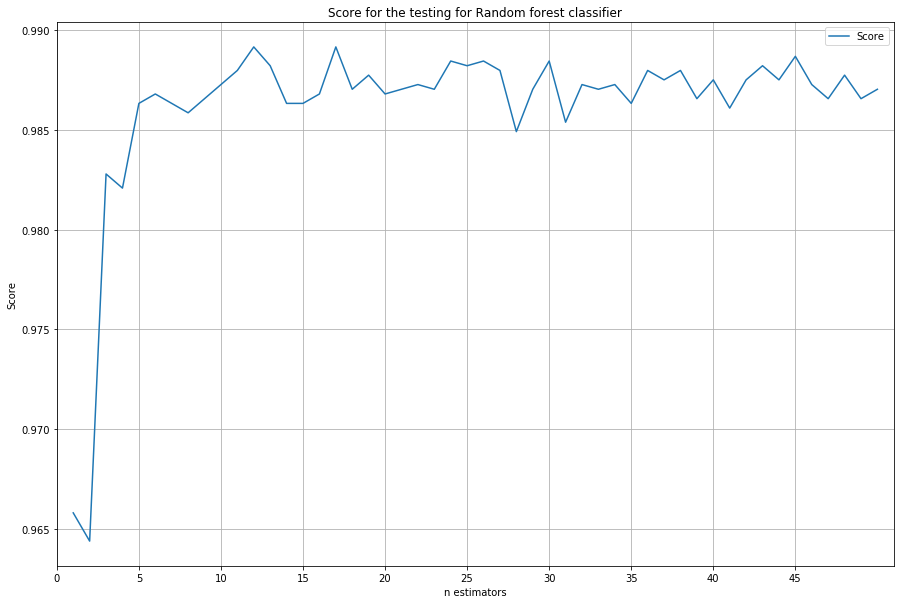

In [28]:
%%time
scores = []
for i in range(50):
    clf = RandomForestClassifier(n_estimators=i+1)
    s = cross_val_score(clf, X_train, Y_train, cv=5)
    scores.append(s.mean())
plot_score(scores, "Random forest classifier", "n estimators");
print("Best number of estimator : " + str(np.argmax(scores) + 1))

Best max depth : 18
CPU times: user 21.7 s, sys: 0 ns, total: 21.7 s
Wall time: 21.7 s


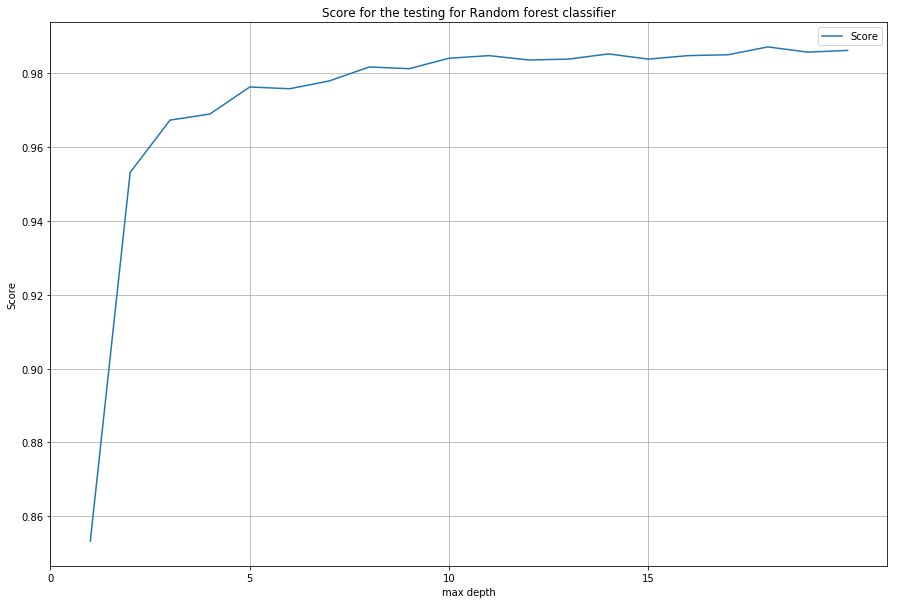

In [29]:
%%time
scores = []
for i in range(20):
    clf = RandomForestClassifier(n_estimators=20, max_depth=i+1)
    s = cross_val_score(clf, X_train, Y_train, cv=5)
    scores.append(s.mean())
plot_score(scores, "Random forest classifier", "max depth");
print("Best max depth : " + str(np.argmax(scores) + 1))

In [30]:
%%time
clf = RandomForestClassifier(n_estimators=20, max_depth=10)
clf.fit(X_train, Y_train)
print("score: " + str(clf.score(X_test, Y_test)))

score: 0.977379830349
CPU times: user 189 ms, sys: 3.33 ms, total: 193 ms
Wall time: 192 ms


In [31]:
importance = list(zip(features, clf.feature_importances_))
importance.sort(key=lambda x:x[1], reverse=True)
for name,i in importance:
    if i == 0:
        break
    print("{} : {:.3}".format(name, i))

ratio_friends_followers_pow : 0.136
ratio_friends_followers : 0.114
tweet_retweet : 0.0843
ratio_followers_friends_pow : 0.0776
tweet_count : 0.0725
ratio_followers_friends : 0.0597
Tweet Button : 0.0539
tweet_mention : 0.0504
Twitter for Android : 0.0379
tweet_hashtag : 0.0358
is_listed : 0.0286
tweet_url : 0.0231
friends_count : 0.022
Instagram : 0.0212
has_biography : 0.0182
tweet_fav : 0.0182
favourites_count : 0.0172
TweetDeck : 0.0117
Twitter for iPhone : 0.0114
web : 0.00757
foursquare : 0.00748
followers_count : 0.0072
iOS : 0.00645
has_location : 0.00624
Safari on iOS : 0.00538
tweet_reply : 0.00534
YouTube on iOS : 0.0051
Photos on iOS : 0.00412
Twitter for iPad : 0.00328
Mobile Web (M5) : 0.00306
Mobile Web : 0.00283
listed_count : 0.00244
Ruzzle on iOS : 0.00227
Google : 0.00207
Mobile Web (M2) : 0.00174
JustUnfollow : 0.00173
Shazam on iOS : 0.00169
Flipboard : 0.00164
Twitterrific : 0.0016
Facebook : 0.00125
Twitter for BlackBerry® : 0.00105
has_url : 0.00101
Miso : 0.000

### Decision tree classifier

Best max depth : 6
CPU times: user 47 s, sys: 0 ns, total: 47 s
Wall time: 47 s


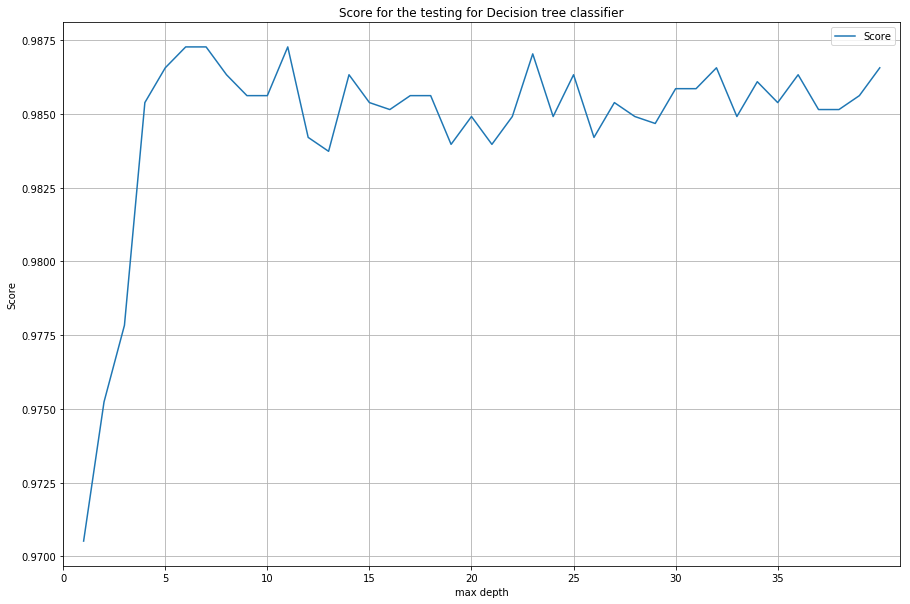

In [32]:
%%time
scores = []
for i in range(40):
    clf = DecisionTreeClassifier(max_depth=i+1)
    s = cross_val_score(clf, X_train, Y_train, cv=5)
    scores.append(s.mean())
plot_score(scores, "Decision tree classifier", "max depth");
print("Best max depth : " + str(np.argmax(scores) + 1))

In [33]:
%%time
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X_train, Y_train)
print("score: " + str(clf.score(X_test, Y_test)))

score: 0.987747408106
CPU times: user 177 ms, sys: 3.3 ms, total: 180 ms
Wall time: 179 ms


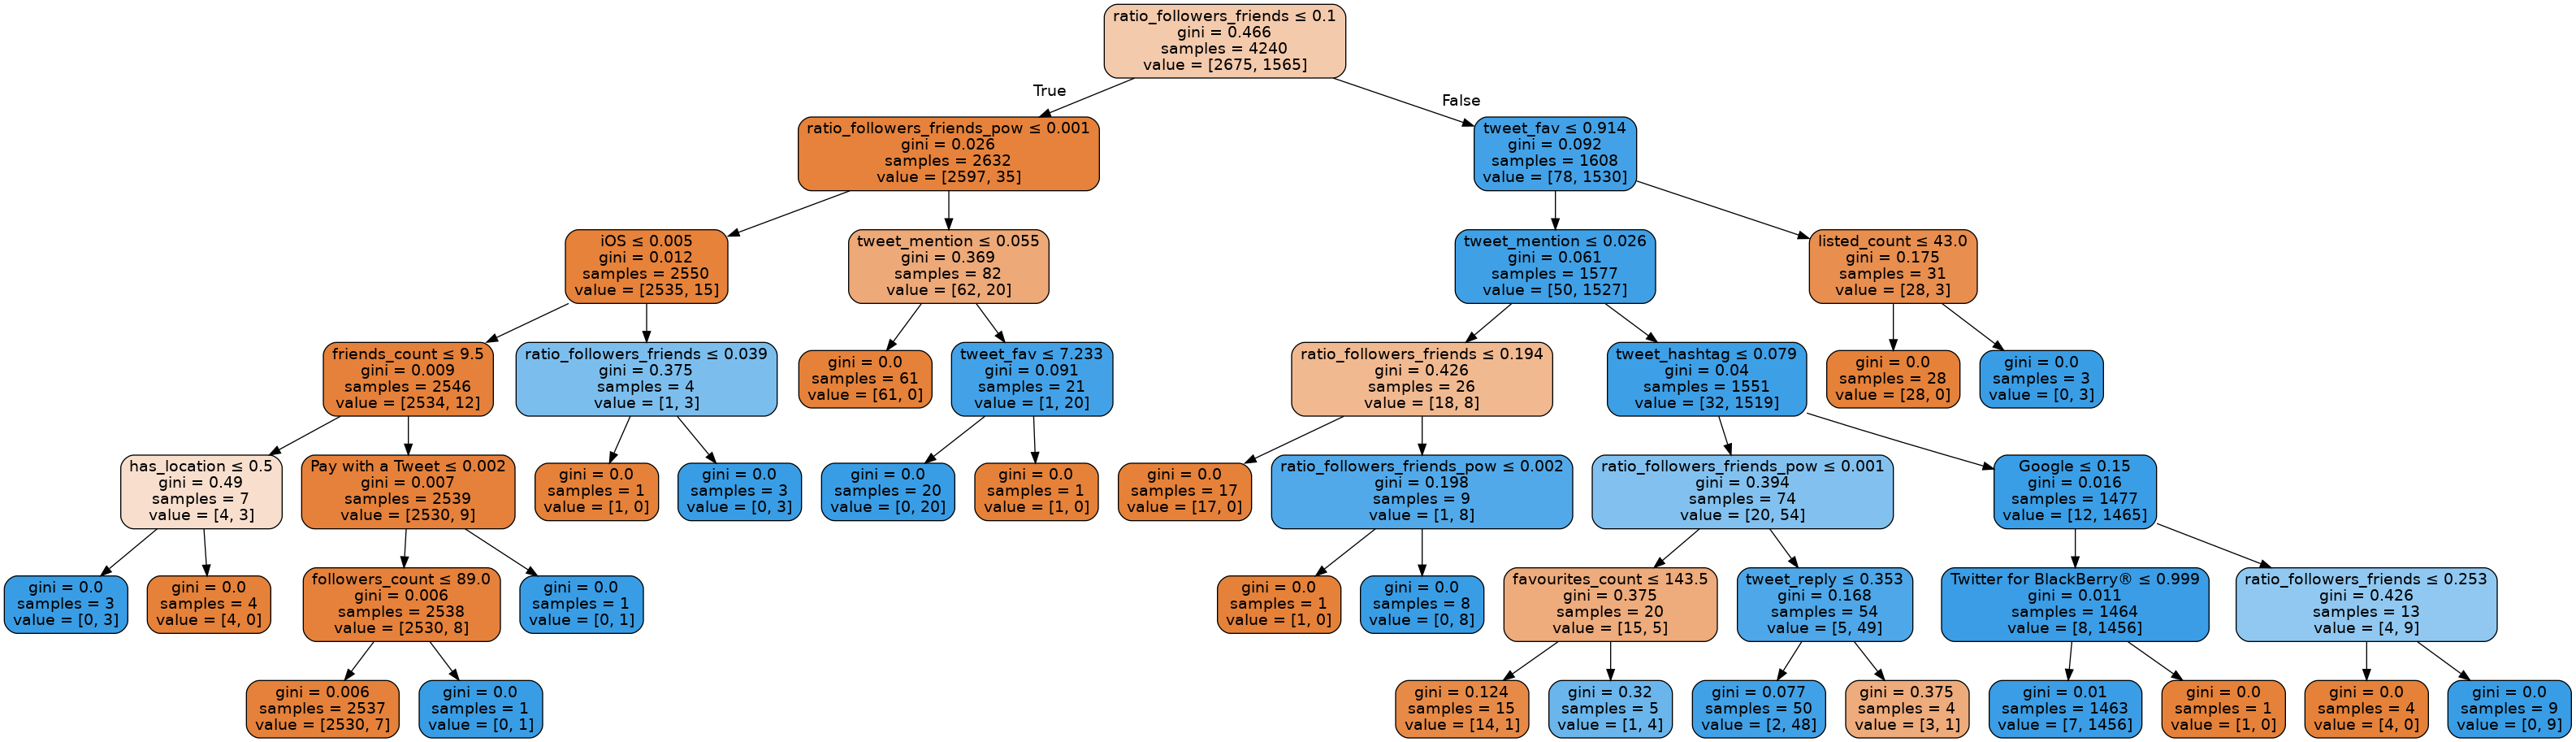

In [34]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=features,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data)
Image(graph[0].create_png())

### Linear SVC

In [35]:
%%time
clf = LinearSVC()
clf.fit(X_train, Y_train)
print("score: " + str(clf.score(X_test, Y_test)))

score: 0.865221489161
CPU times: user 381 ms, sys: 16.7 ms, total: 398 ms
Wall time: 397 ms


### KNN

Best number of neighbors : 1
CPU times: user 1min 48s, sys: 893 ms, total: 1min 49s
Wall time: 1min 49s


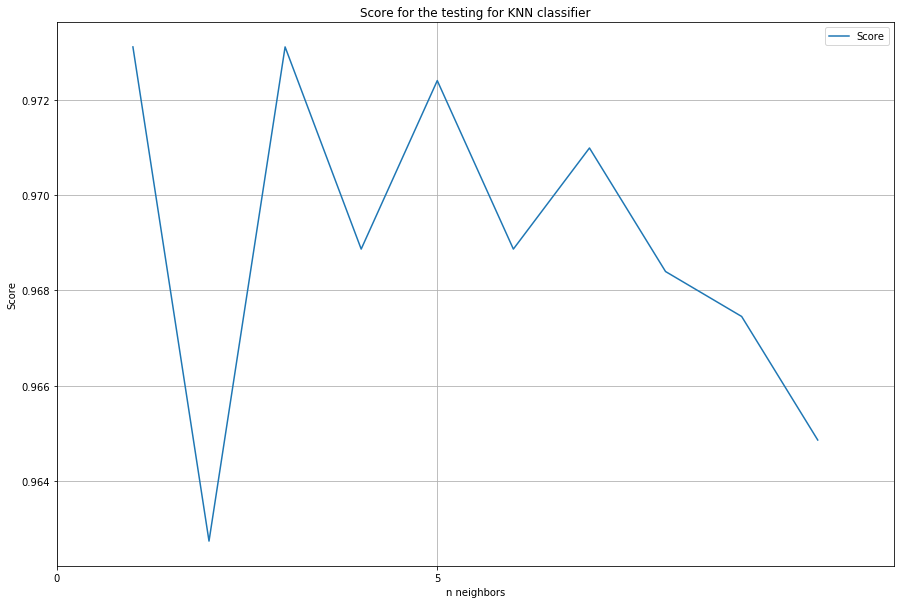

In [36]:
%%time
scores = []
for i in range(10):
    clf = KNeighborsClassifier(n_neighbors=i+1)
    s = cross_val_score(clf, X_train, Y_train, cv=5)
    scores.append(s.mean())
scores = np.array(scores)
plot_score(scores, "KNN classifier", "n neighbors");
print("Best number of neighbors : " + str(scores.argmax() + 1))

In [37]:
%%time
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, Y_train)
print("score: " + str(clf.score(X_test, Y_test)))

score: 0.973609802074
CPU times: user 2.91 s, sys: 46.6 ms, total: 2.96 s
Wall time: 2.96 s
